# Nasdaq Data Analysis

The goal of this notebook is to extract financial data from the Nasdaq Data Link API and then analyse this data (financial performance of companies over time, variations in companies, geographical location).

In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import requests

In [21]:
from config import API_KEY

parameters = {"api_key": API_KEY, "qopts.per_page": 10_000}

endpoint_api = "https://data.nasdaq.com/api/v3/datatables/MER/F1.json"

res = requests.get(endpoint_api, params=parameters)
json_data = res.json()

In [13]:
data_df = pd.DataFrame(
    json_data["datatable"]["data"], columns=[col["name"] for col in json_data["datatable"]["columns"]]
)

Now that we have imported the data, we have two primary aims:
1. Analyze "Accrued Expense Turnover" (how often company pays off its accrued expenses) for various companies (esp. banks).
2. Examine the influence of regions on this metric.

In [52]:
necessary_columns = [
    "compnumber",
    "reportid",
    "mapcode",
    "amount",
    "reportdate",
    "reporttype",
    "currency",
    "longname",
    "city",
    "country",
    "indicator",
    "statement",
]

indicator_filter = "Accrued Expenses Turnover"

data_filtered_df = data_df.loc[data_df["indicator"] == indicator_filter, necessary_columns]

data_filtered_df = data_filtered_df.rename(
    columns={
        "compnumber": "company_number",
        "reportid": "report_id",
        "mapcode": "map_code",
        "reportdate": "report_date",
        "reporttype": "report_type",
        "longname": "company_name",
    }
)

The metric has a large deviation around the mean, indicating the companies in the dataset display very different financial management.

In [53]:
data_filtered_df["amount"].describe()

count    139.000000
mean      26.908762
std       33.097291
min        4.689773
25%        9.675670
50%       13.753753
75%       31.777614
max      229.810427
Name: amount, dtype: float64

We can group the various datapoints by regions of the world with 4 big regions: Europe, Asia, North America 

In [58]:
display(set(data_filtered_df["country"]))
display(data_filtered_df["country"].value_counts())
regions = {
    "DEU": "Europe",
    "BHS": "Central America",
    "GBR": "Europe",
    "JPN": "Asia",
    "CYM": "Central America",
    "USA": "North America",
    "IRL": "Europe",
}
data_filtered_df["region"] = data_filtered_df["country"].apply(lambda x: regions[x])
display(data_filtered_df["region"].value_counts())

{'BHS', 'CYM', 'DEU', 'GBR', 'IRL', 'JPN', 'USA'}

country
USA    31
JPN    27
CYM    27
IRL    25
BHS    19
DEU     6
GBR     4
Name: count, dtype: int64

region
Central America    46
Europe             35
North America      31
Asia               27
Name: count, dtype: int64

We see that when grouping by regions, we find two types of behaviours: the asian and european companies with a distribution very peaked on its mean while the two american regions are relatively spread out around their means.

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Asia,27.0,10.376605,0.702919,9.129244,9.864493,10.244816,10.902160,12.120226
Central America,46.0,36.313772,40.379456,4.689773,14.166878,16.579988,50.553777,229.810427
Europe,35.0,11.828886,14.090997,6.466191,6.969867,7.552247,8.540956,82.525319
North America,31.0,44.377585,37.490348,11.775064,23.157954,31.590961,40.005448,147.952941


[(0.0, 40.0), (0.0, 40.0)]

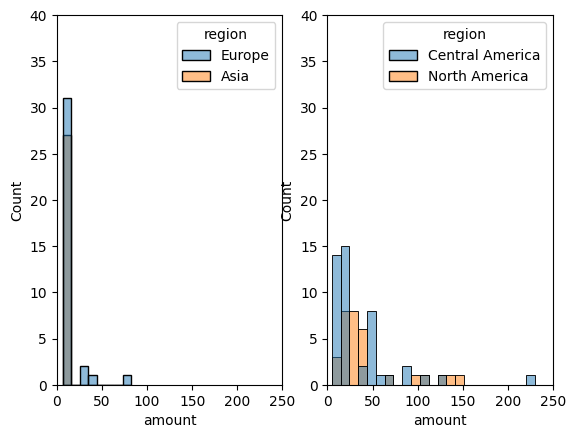

In [55]:
display(data_filtered_df.groupby("region").describe()["amount"])

fig, axs = plt.subplots(ncols=2)
sns.histplot(
    data_filtered_df.loc[data_filtered_df["region"].isin(["Europe", "Asia"])],
    x="amount",
    hue="region",
    ax=axs[0],
    binwidth=10,
)
sns.histplot(
    data_filtered_df.loc[data_filtered_df["region"].isin(["North America", "Central America"])],
    x="amount",
    hue="region",
    ax=axs[1],
    binwidth=10,
)
[ax.set_xlim(0, 250) for ax in axs]
[ax.set_ylim(0, 40) for ax in axs]

Now we are interested in time series of this data over the period 2010-2015.

In [61]:
data_filtered_df["report_date"] = pd.to_datetime(data_filtered_df["report_date"])
data_filtered_time_df = data_filtered_df.loc[
    (data_filtered_df["report_date"].dt.year >= 2010) & (data_filtered_df["report_date"].dt.year <= 2015)
]

In [79]:
relevant_columns = ["company_name", "report_date", "amount"]
relevant_data_df = data_filtered_time_df[relevant_columns]
companies = list(set(relevant_data_df["company_name"]))

In [86]:
tmp_df = relevant_data_df.loc[relevant_data_df["company_name"] == companies[0], ["report_date", "amount"]].set_index(
    "report_date"
)

We see some companies are relatively stable (Apple, Herbalife) while others show large fluctuations like Ultrapetrol.

Text(38.347222222222214, 0.5, 'Accrued Expense Turnover')

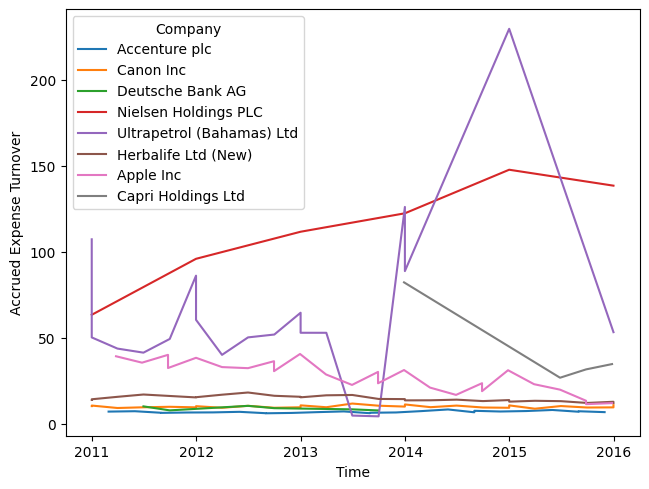

In [105]:
fig, ax = plt.subplots()
for company in companies:
    tmp_df = relevant_data_df.loc[relevant_data_df["company_name"] == company, ["report_date", "amount"]]
    ax.plot(tmp_df["report_date"].to_numpy(), tmp_df["amount"].to_numpy(), label=company)

ax.legend(title="Company", loc="upper left")
fig.tight_layout()
ax.set_xlabel("Time")
ax.set_ylabel("Accrued Expense Turnover")